<a href="https://colab.research.google.com/github/MMillward2012/deepmind_internship/blob/main/notebooks/4_train_tinyBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup & Imports

This cell loads all required libraries for data preprocessing, model training, evaluation, and saving.  
Make sure this cell runs without errors before continuing with the notebook.

In [46]:
# %cd ..

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
import os

### Model Options for Financial Sentiment Classification

This project supports fine-tuning and evaluation of a variety of **small transformer models** designed for natural language understanding and sentiment analysis. Below are the key models considered, ranging from lightweight general-purpose models to domain-specific financial sentiment models:

| Model Name                                  | Approximate Size | Category             | Description                                                                                     |
|---------------------------------------------|------------------|----------------------|-------------------------------------------------------------------------------------------------|
| `huawei-noah/TinyBERT_General_4L_312D`     | ~14 million      | Tiny Transformer     | A compact, fast transformer designed for resource-efficient training and inference.             |
| `distilbert-base-uncased`                   | ~66 million      | Distilled BERT       | Smaller, faster version of BERT retaining strong performance, a common baseline.                 |
| `sentence-transformers/all-MiniLM-L6-v2`   | ~22 million      | MiniLM               | Ultra-compact encoder model optimized for sentence embeddings and classification.               |
| `google/mobilebert-uncased`                  | ~25 million      | MobileBERT           | Efficient transformer model optimised for mobile and edge devices.                              |
| `unsloth/SmolLM2-360M-Instruct`             | ~360 million     | Small Instruction-Tuned LLM | New generation small LLM with instruction tuning for robust language understanding.            |
| `ProsusAI/finbert`                          | ~110 million     | Domain-Specific BERT | Financial domain-adapted BERT, fine-tuned on financial sentiment tasks for superior accuracy.   |

---

### Notes:

- All models use the **transformer architecture**, but differ in size, design goals, and training data.  
- Smaller models like TinyBERT, MiniLM, and MobileBERT are well-suited for fast training and deployment in resource-constrained environments.  
- Larger domain-specific models such as FinBERT provide specialized knowledge for financial sentiment classification but require more computational resources.  
- The newer SmolLM family provides instruction-tuned capabilities in a relatively small model size, offering a promising balance between performance and efficiency.  
- This notebook implements a **generalized fine-tuning and evaluation pipeline** to easily train and compare any of these models on the FinancialPhraseBank dataset.


In [48]:
CSV_PATH = "data/FinancialPhraseBank/all-data.csv"
MODEL_NAME = "huawei-noah/TinyBERT_General_4L_312D"
MAX_LENGTH = 128
BATCH_SIZE = 16
NUM_EPOCHS = 3
SEED = 42
OUTPUT_DIR = "models/tinybert-financial-classifier"

### Data Loading and Preprocessing

These functions handle the initial stages of preparing the dataset:

- `load_and_process_data`: Loads the FinancialPhraseBank CSV file and removes any extra quotation marks from sentences.
- `encode_and_split`: Converts string sentiment labels into numeric form using `LabelEncoder`, and splits the data into training and validation sets using stratified sampling.

These steps are crucial for preparing the data for fine-tuning transformer models on sentiment classification.

In [49]:
def load_and_process_data(csv_path):
    df = pd.read_csv(csv_path, header=None, names=["label", "sentence"], encoding="latin-1")
    df["sentence"] = df["sentence"].str.strip('"')
    return df

def encode_and_split(df, seed=SEED):
    le = LabelEncoder()
    df["label"] = le.fit_transform(df["label"])
    train_df, val_df = train_test_split(df, test_size=0.25, stratify=df["label"], random_state=seed)
    return train_df, val_df, le


# Dataset Preparation Functions

In [50]:
def prepare_datasets(train_df, val_df, tokenizer, max_length=MAX_LENGTH):
    train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
    val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

    def tokenize_fn(example):
        return tokenizer(example["sentence"], truncation=True, padding="max_length", max_length=max_length)

    train_dataset = train_dataset.map(tokenize_fn, batched=True)
    val_dataset = val_dataset.map(tokenize_fn, batched=True)

    train_dataset = train_dataset.remove_columns(["sentence"])
    val_dataset = val_dataset.remove_columns(["sentence"])
    train_dataset = train_dataset.rename_column("label", "labels")
    val_dataset = val_dataset.rename_column("label", "labels")

    train_dataset.set_format("torch")
    val_dataset.set_format("torch")

    return train_dataset, val_dataset


# Model and Training Setup Functions

In [51]:
def get_model(model_name, num_labels):
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

def get_training_args(output_dir, batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, seed=SEED):
    return TrainingArguments(
        output_dir=output_dir,
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        save_total_limit=2,
        seed=seed,
    )


# Metrics and Evaluation Functions

In [52]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

def plot_confusion_matrix(trainer, val_dataset, label_encoder):
    predictions = trainer.predict(val_dataset)
    y_true = predictions.label_ids
    y_pred = predictions.predictions.argmax(axis=1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot()
    plt.show()


# Run Training and Evaluation

Training samples: 3634
Validation samples: 1212
Classes: ['negative', 'neutral', 'positive']


Map:   0%|          | 0/3634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.706000,0.664036,0.772277
2,0.535200,0.559646,0.791254
3,0.465700,0.547999,0.789604


/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Model, tokenizer, and label encoder saved to 'models/tinybert-financial-classifier'


/Users/matthew/Documents/deepmind_internship/venv-py311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


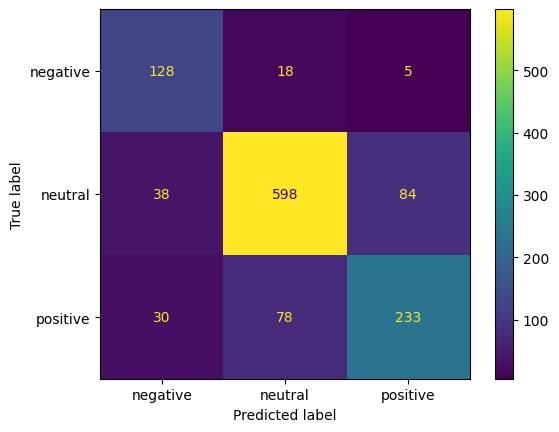

In [53]:
# Load and preprocess data
df = load_and_process_data(CSV_PATH)
train_df, val_df, label_encoder = encode_and_split(df)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Classes: {list(label_encoder.classes_)}")

# Tokeniser and dataset prep
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset, val_dataset = prepare_datasets(train_df, val_df, tokenizer)

# Model and training setup
model = get_model(MODEL_NAME, num_labels=len(label_encoder.classes_))
training_args = get_training_args(OUTPUT_DIR)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Train model
trainer.train()

# Save final model, tokenizer, and label encoder
os.makedirs(OUTPUT_DIR, exist_ok=True)
trainer.model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
with open(os.path.join(OUTPUT_DIR, "label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)
print(f"Model, tokenizer, and label encoder saved to '{OUTPUT_DIR}'")

# Plot confusion matrix
plot_confusion_matrix(trainer, val_dataset, label_encoder)